In [4]:
!pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 4.2 MB/s eta 0:00:00


In [5]:
import numpy as np
import control as ctl
import matplotlib.pyplot as plt

### **Phase-lead compensator using root locus**
Phase-lead compensator is defined as,
$$ C(s)=K\frac{(s-z_{0})}{(s-p_{0})}, \;\; |z_0|<|p_0|.$$
Let $G(s)=\frac{40}{s(s+2)}$ and the requirements are
* $K_v>20$
* $\zeta=0.4$
* $\omega_n=10$

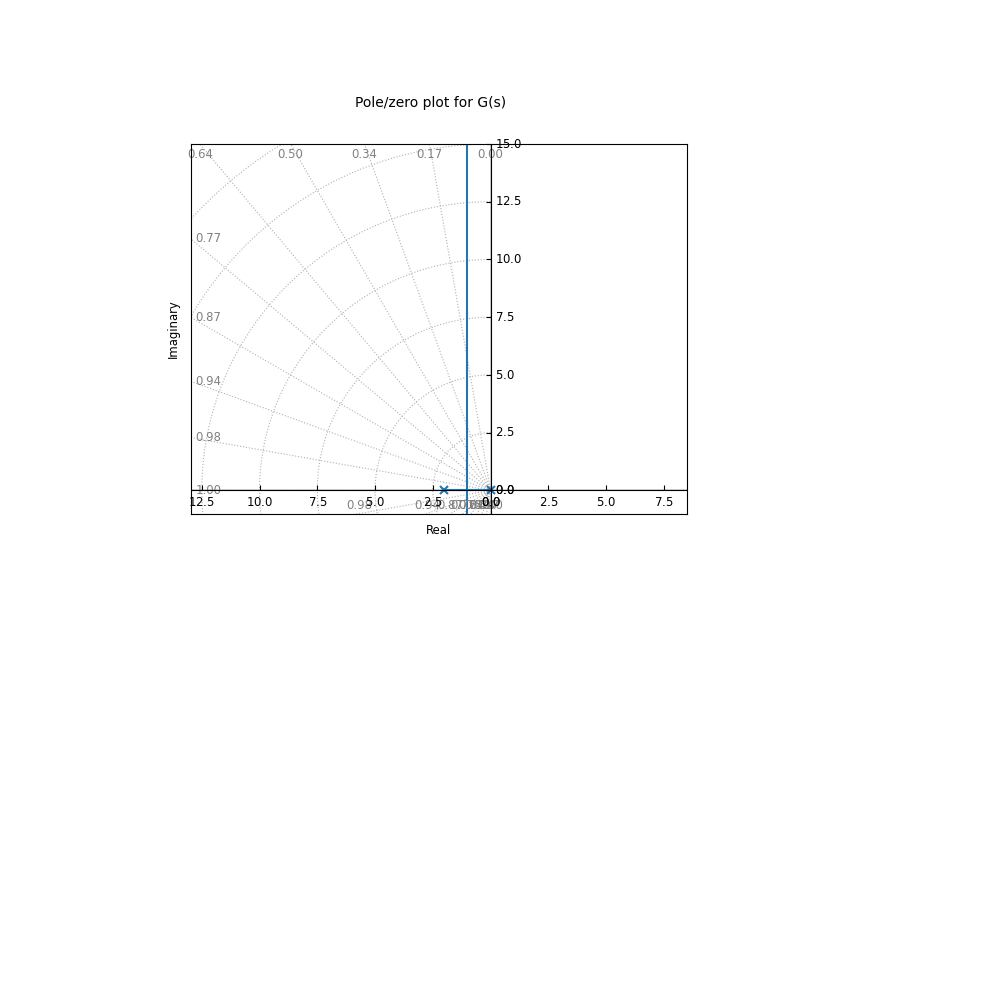

In [6]:
s=ctl.tf('s')
G = 40/(s*(s+2))
G.name = 'G(s)'
zeta = 0.4
omega_n = 10
results = ctl.root_locus(G, xlim=(-5,0.5), ylim=(-1,15))

Set $z_0=-\zeta \cdot \omega_n$

In [7]:
z_0 = -zeta*omega_n
z_0

-4.0

In [8]:
desired_root = z_0+1j*(omega_n**2-z_0**2)**0.5
desired_root

(-4+9.16515138991168j)

In [9]:
poles = ctl.poles(G)
angle_p_0 = np.pi-(sum(np.angle(desired_root-poles))-np.angle(desired_root-z_0))
angle_p_0

0.9444296476516962

In [10]:
p_0 = z_0 - (omega_n**2-z_0**2)**0.5 / np.tan(angle_p_0)
p_0

-10.631578947368421

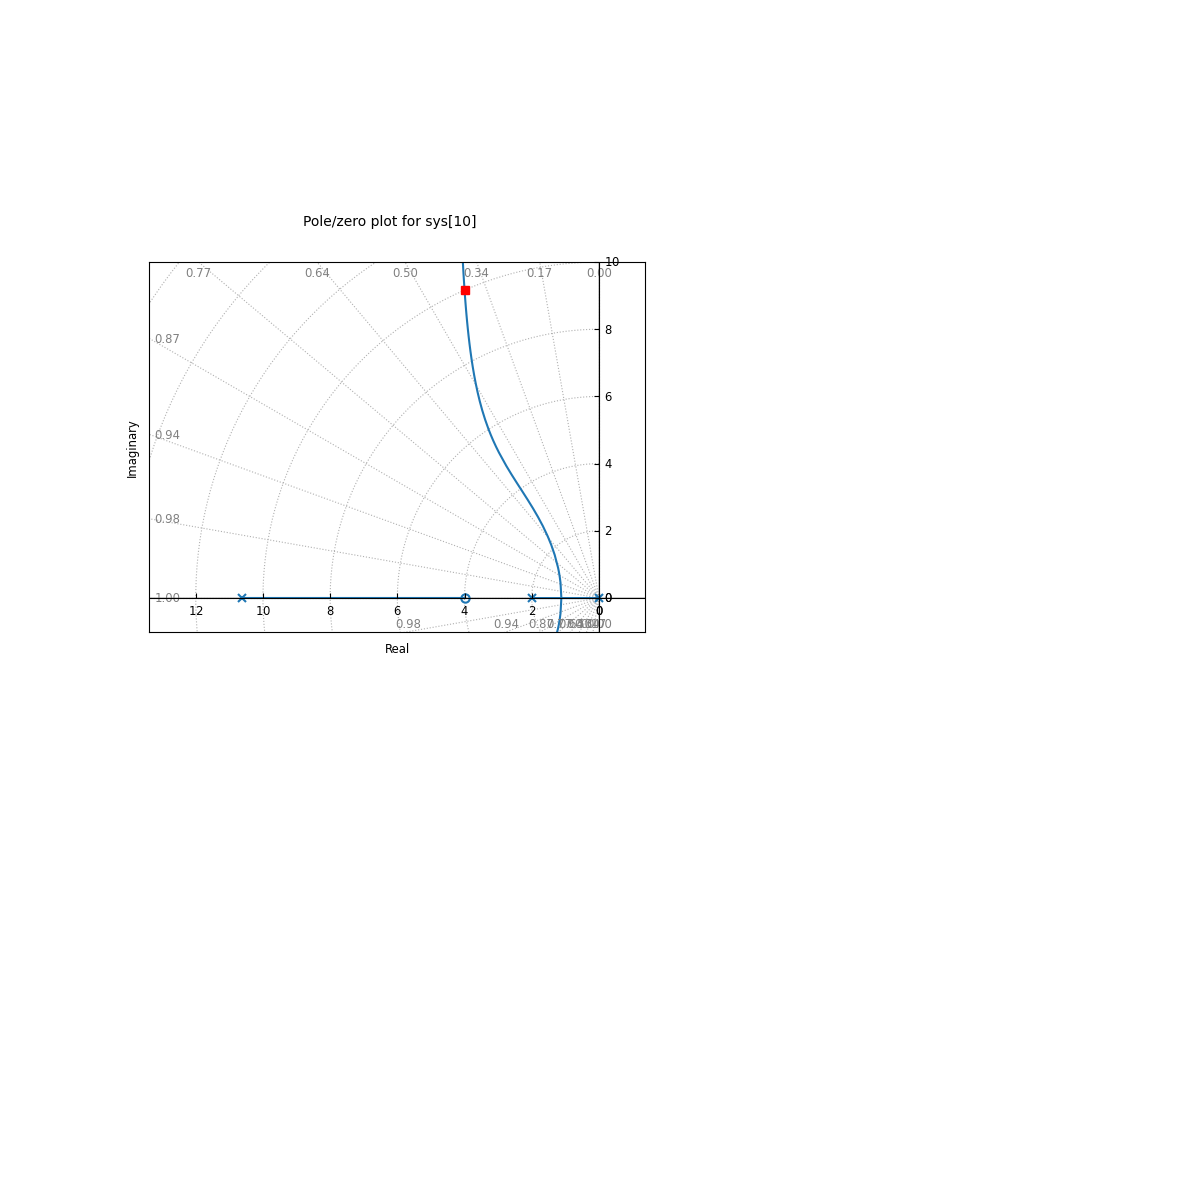

In [11]:
C_lead = (s-z_0)/(s-p_0)
results = ctl.root_locus(C_lead*G, xlim=(-12,0), ylim=(-1, 10))
plot_root = plt.plot(desired_root.real, desired_root.imag, 'rs')

In [12]:
rlist, klist = ctl.root_locus(C_lead*G, kvect=np.linspace(0, 10, 1000), plot=False)
distances = np.min(np.abs(rlist - desired_root),axis=1)
closest_idx = np.argmin(distances)
K = klist[closest_idx]
K

2.8928928928928928

In [13]:
C_lead = (s-z_0)/(s-p_0) * K
Kv = ctl.dcgain(ctl.minreal(G*C_lead*s))
Kv

1 states have been removed from the model


21.768302956421767

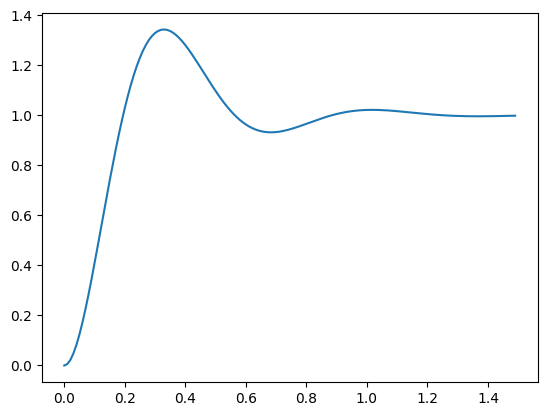

In [14]:
sys_cl = ctl.feedback(G*C_lead,1)
t,y = ctl.step_response(sys_cl, np.arange(0, 1.5, 0.01))
result = plt.plot(t,y)

In [15]:
ctl.step_info(sys_cl)

{'RiseTime': 0.13956024882631715,
 'SettlingTime': 1.0641468973006682,
 'SettlingMin': 0.931400253036462,
 'SettlingMax': 1.3421386540504088,
 'Overshoot': 34.21386540504088,
 'Undershoot': 0,
 'Peak': 1.3421386540504088,
 'PeakTime': 0.3314555909625032,
 'SteadyStateValue': 1.0}

### **Phase-lead compensator using frequency response**
Phase-lead compensator is defined as,
$$ C(s)=K\frac{(s-z_{0})}{(s-p_{0})}, \;\; |z_0|<|p_0|.$$
Let $G(s)=\frac{40}{s(s+2)}$ and the requirements are
* $K_v>20$
* PM $>0.4$

17.964235916371365

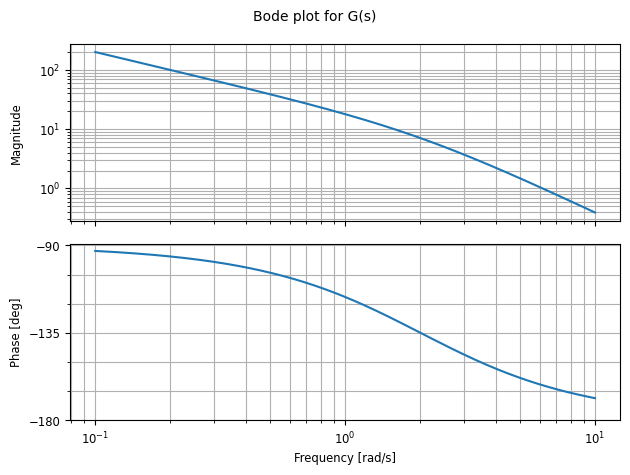

In [16]:
bode_G = ctl.bode(G)
gm, pm, Wcg, Wcp = ctl.margin(G)
pm

In [17]:
pm_desired = 40
pm_required = pm_desired - pm + 8
pm_required

30.035764083628635

$$sin(\phi_m) = \frac{\alpha-1}{\alpha+1}, \alpha = \frac{p_0}{z_0}$$

In [18]:
from sympy.solvers import solve
from sympy import Symbol

In [19]:
a = Symbol('a')
sol = solve(np.sin(np.deg2rad(pm_required))-(a-1)/(a+1))
sol

[3.00432849083701]

In [43]:
alpha = float(sol[0])
C_gain_center = alpha**0.5
frequencies = np.linspace(1, 10, 1000)
mag, phase, omega = ctl.freqresp(G, frequencies)
closest_idx = np.argmin(np.abs(mag - 1/C_gain_center))
omega_m = omega[closest_idx]
omega_m

8.207207207207208

In [44]:
z_0 = -omega_m/C_gain_center
z_0

-4.735018607524815

In [45]:
p_0 = alpha*z_0
p_0

-14.225551307230202

In [47]:
C_lead_ = (s-z_0)/(s-p_0)
Kv = ctl.dcgain(ctl.minreal(G*C_lead_*s))
Kv

1 states have been removed from the model


6.657061656539413

In [50]:
C_lead = C_lead_ * 20/Kv
Kv = ctl.dcgain(ctl.minreal(G*C_lead*s))
Kv

1 states have been removed from the model


19.999999999999996

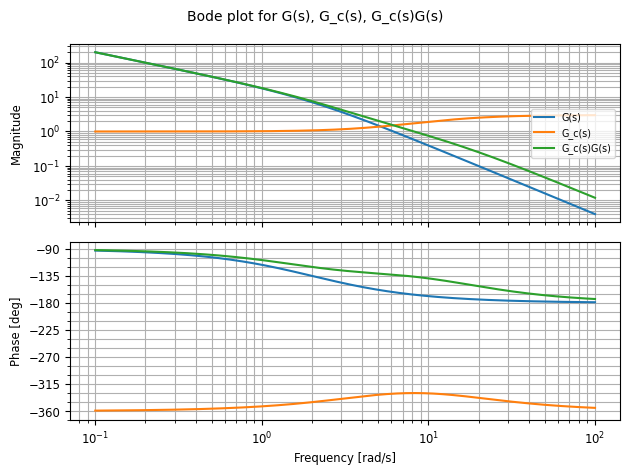

In [54]:
C_lead.name = 'G_c(s)'
G_comp = G*C_lead
G_comp.name = 'G_c(s)G(s)'
sys_list = [G, C_lead, G_comp]
result = ctl.bode(sys_list)

In [55]:
gm_1, pm_1, Wcg_1, Wcp_1 = ctl.margin(G)
gm_2, pm_2, Wcg_2, Wcp_2 = ctl.margin(G_comp)
print('G, GM = %.2f dB (at %.2f rad/s) and PM = %.2f dB (at %.2f rad/s)' % (gm_1, Wcg_1, pm_1, Wcp_1))
print('G_comp, GM = %.2f dB (at %.2f rad/s) and PM = %.2f dB (at %.2f rad/s)' % (gm_2, Wcg_2, pm_2, Wcp_2))

G, GM = inf dB (at nan rad/s) and PM = 17.96 dB (at 6.17 rad/s)
G_comp, GM = inf dB (at nan rad/s) and PM = 43.73 dB (at 8.21 rad/s)


### **Phase-lag compensator using root locus**
Phase-lag compensator is defined as,
$$ C(s)=K\frac{(s-z_{0})}{(s-p_{0})}, \;\; |z_0|>|p_0|.$$
Let $G(s)=\frac{40}{s(s+2)}$ and the requirements are
* $K_v>20$
* $\zeta=0.4$

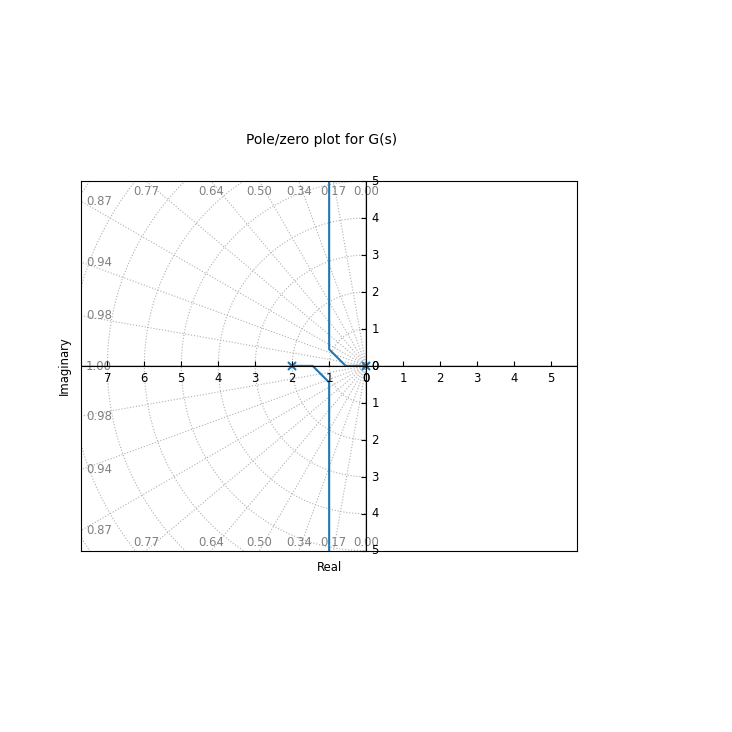

In [103]:
Kv_desired = 20
zeta = 0.4
rlist, klist = ctl.root_locus(G, kvect=np.linspace(0, 10, 1000), xlim=(-2.5, 0.5), ylim=(-5, 5), plot=True)

In [105]:
root_real = -1
theta = np.arccos(zeta)
root_angle = np.pi-theta
angles = np.min(np.abs(np.angle(rlist) - root_angle),axis=1)
closest_idx = np.argmin(angles)
K = klist[closest_idx]
K

0.16016016016016016

In [107]:
Kv = ctl.dcgain(ctl.minreal(K*G*s))
Kv

1 states have been removed from the model


3.203203203203203

In [108]:
alpha = Kv_desired / Kv
alpha

6.24375

In [110]:
z_0 = -0.1
p_0 = -0.1/alpha
z_0, p_0

(-0.1, -0.016016016016016016)

In [111]:
C_lag = K * (s-z_0) / (s-p_0)
C_lag

TransferFunction(array([0.16016016, 0.01601602]), array([1.        , 0.01601602]))

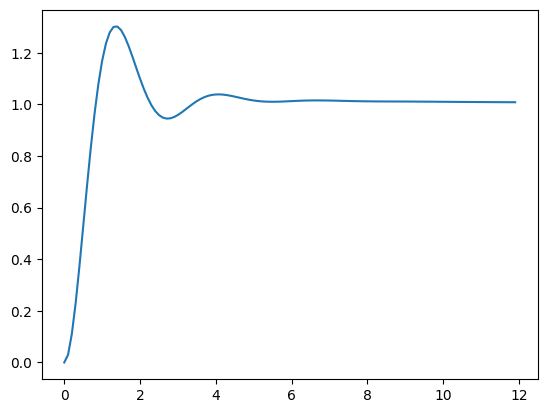

In [114]:
sys_cl = ctl.feedback(C_lag*G,1)
t,y = ctl.step_response(sys_cl, np.arange(0,12,0.1))
result = plt.plot(t,y)

In [117]:
ctl.step_info(sys_cl)

{'RiseTime': 0.6027358403193015,
 'SettlingTime': 4.821886722554412,
 'SettlingMin': 0.9446154329113723,
 'SettlingMax': 1.3010305356637417,
 'Overshoot': 30.10305356637417,
 'Undershoot': 0,
 'Peak': 1.3010305356637417,
 'PeakTime': 1.4063836274117036,
 'SteadyStateValue': 1.0}

### **Phase-lag compensator using root locus**
Phase-lag compensator is defined as,
$$ C(s)=K\frac{(s-z_{0})}{(s-p_{0})}, \;\; |z_0|>|p_0|.$$
Let $G(s)=\frac{40}{s(s+2)}$ and the requirements are
* $K_v>20$
* PM $>40$

17.964235916371365

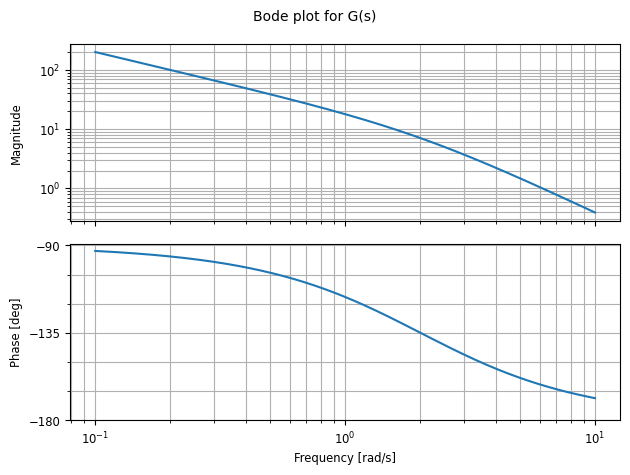

In [118]:
bode_G = ctl.bode(G)
gm, pm, Wcg, Wcp = ctl.margin(G)
pm

In [124]:
pm_desired = 50
phase_desired = np.deg2rad(-180+pm_desired)
frequencies = np.linspace(1, 10, 1000)
mag, phase, omega = ctl.freqresp(G, frequencies)
closest_idx = np.argmin(np.abs(phase - phase_desired))
omega_c = omega[closest_idx]
alpha = mag[closest_idx]
omega_c, alpha

(1.6756756756756757, 9.148792839892277)

In [125]:
z_0 = -omega_c/10
p_0 = z_0/alpha
K = 1/alpha
C_lag = K * (s-z_0) / (s-p_0)
C_lag

TransferFunction(array([0.10930404, 0.01831581]), array([1.        , 0.01831581]))

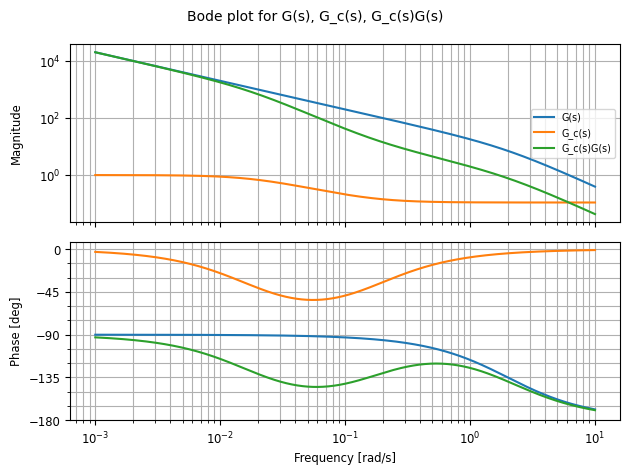

In [127]:
C_lag.name = 'G_c(s)'
G_comp = G*C_lag
G_comp.name = 'G_c(s)G(s)'
sys_list = [G, C_lag, G_comp]
result = ctl.bode(sys_list)

In [128]:
gm_1, pm_1, Wcg_1, Wcp_1 = ctl.margin(G)
gm_2, pm_2, Wcg_2, Wcp_2 = ctl.margin(G_comp)
print('G, GM = %.2f dB (at %.2f rad/s) and PM = %.2f dB (at %.2f rad/s)' % (gm_1, Wcg_1, pm_1, Wcp_1))
print('G_comp, GM = %.2f dB (at %.2f rad/s) and PM = %.2f dB (at %.2f rad/s)' % (gm_2, Wcg_2, pm_2, Wcp_2))

G, GM = inf dB (at nan rad/s) and PM = 17.96 dB (at 6.17 rad/s)
G_comp, GM = inf dB (at nan rad/s) and PM = 44.88 dB (at 1.68 rad/s)
